In [26]:
import pandas as pd

%matplotlib inline

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/abevieiramota/analysis-ufc/master/data/processed/fcpc/fisica.csv")

In [30]:
df['data'] = pd.to_datetime(df.data, format='%Y-%m-%d')

In [3]:
df.shape

(126680, 7)

In [16]:
df.head()

,cpf,nome,tipo_pagamento,projeto,data,valor,filename
0,***.000.103-**,REGILDA RODRIGUES DE SOUSA,ADIANTAMENTO PARA VIAGENS,2213 - CT - UFC/FCPC - PROJETO PROJOVEM CAMPO,2010-11-22,240.0,2010.csv
1,***.000.103-**,REGILDA RODRIGUES DE SOUSA,ADIANTAMENTO PARA VIAGENS,2213 - CT - UFC/FCPC - PROJETO PROJOVEM CAMPO,2010-10-15,180.0,2010.csv
2,***.000.103-**,REGILDA RODRIGUES DE SOUSA,ADIANTAMENTO PARA VIAGENS,2213 - CT - UFC/FCPC - PROJETO PROJOVEM CAMPO,2010-08-18,180.0,2010.csv
3,***.000.103-**,REGILDA RODRIGUES DE SOUSA,ADIANTAMENTO PARA VIAGENS,2213 - CT - UFC/FCPC - PROJETO PROJOVEM CAMPO,2010-05-21,300.0,2010.csv
4,***.000.103-**,REGILDA RODRIGUES DE SOUSA,ADIANTAMENTO PARA VIAGENS,2213 - CT - UFC/FCPC - PROJETO PROJOVEM CAMPO,2010-03-03,180.0,2010.csv


In [17]:
df[df['nome'] == 'ABELARDO VIEIRA MOTA']

,cpf,nome,tipo_pagamento,projeto,data,valor,filename
14181,***.692.163-**,ABELARDO VIEIRA MOTA,SERVIÇO PRESTADO - RPA,2266 - CARTA LG/FCPC - OUTROS CORRELATOS,2010-11-22,428.58,2010.csv


In [19]:
df.nlargest(1, 'valor')

,cpf,nome,tipo_pagamento,projeto,data,valor,filename
122957,***.839.713-**,FRANCISCO EDUARDO ARAUJO SOARES,SERVIÇO PRESTADO - RPA,3098 - CT - FCPC/IPLANFOR - PLANO ESTRATÉGICO ...,2016-12-19,328428.65,2016.csv


In [24]:
df.groupby('nome').valor.sum().nlargest(1)

nome
FRANCISCO EDUARDO ARAUJO SOARES    1009837.94
Name: valor, dtype: float64

In [32]:
df.groupby(df.data.dt.year).valor.sum()

data
2010    2.804037e+07
2011    2.481158e+07
2012    2.392721e+07
2013    2.771321e+07
2014    3.535305e+07
2015    3.719548e+07
2016    3.058970e+07
2017    2.719073e+06
Name: valor, dtype: float64

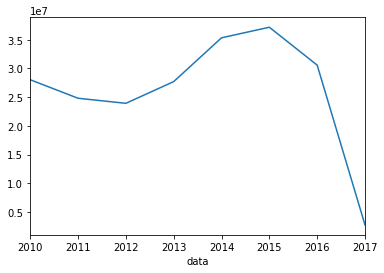

In [33]:
df.groupby(df.data.dt.year).valor.sum().plot()

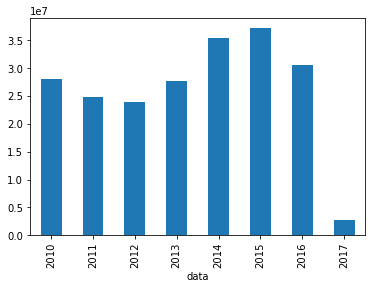

In [34]:
df.groupby(df.data.dt.year).valor.sum().plot('bar')

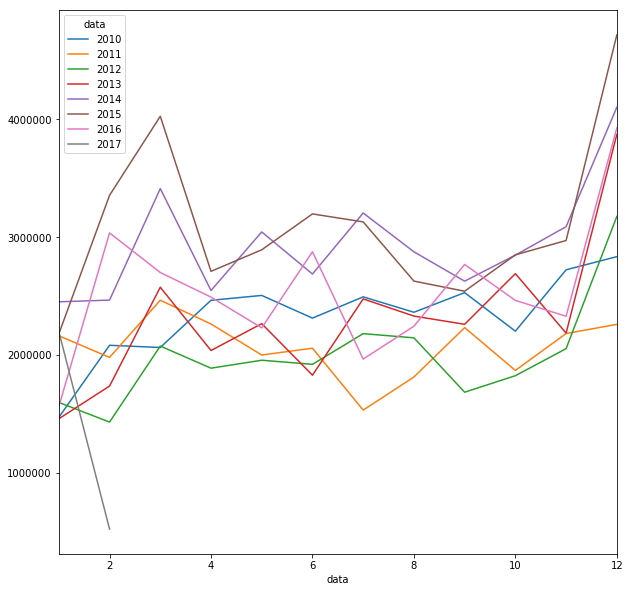

In [50]:
df.groupby([df.data.dt.year, df.data.dt.month]).valor.sum().unstack(0).plot(figsize=(10, 10))

In [55]:
df.groupby("projeto").valor.describe().unstack()

,count,mean,std,min,25%,50%,75%,max
projeto,,,,,,,,
0101 - FCPC,4591.0,2460.428225,2490.468346,0.00,1025.3100,1849.070,3271.1700,90238.33
0104 - FCPC - 124.176-1 - ENCARGOS,12.0,249.620833,207.864046,35.00,83.2500,137.225,480.0000,575.00
1016 - CARTA - UFC/FCPC RADIO UNIVERSITARIA FM,4.0,1871.827500,18.245000,1844.46,1871.8275,1880.950,1880.9500,1880.95
1016 - CARTA - UFC/FCPC RADIO UNIVERSITARIA FM,427.0,1510.971499,748.859090,18.12,1100.0000,1496.000,1859.4100,5634.97
1017 - CT - UFC/FCPC - PROJETO DE ORIENTAÇÃO FARMACEUTICA AOS USUARIOS DA FARMÁCIA UNIVERSITÁRIA DA FARMÁCIA-ESCOLA,542.0,1084.797528,509.735417,0.00,809.1425,1041.360,1189.7575,3600.00
1019 - CT - RNP/INTERNET,52.0,4714.154615,3062.076641,431.30,2000.0000,5300.000,5300.0000,14133.26
1021 - CT/SAMEAC,154.0,773.387922,295.628355,512.29,539.6300,671.710,853.9400,2040.00
1048 - LEMA - LAB. ESTATISTICA E MAT. APLICADA,5.0,314.038000,294.663519,0.00,57.1500,300.000,531.0000,682.04
1088 - CURSO LIA-EXTENSAO,1.0,751.320000,NaN,751.32,751.3200,751.320,751.3200,751.32
